In [1]:
import cv2
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
from patchify import patchify
import matplotlib.pyplot as plt
from tifffile import imread, imsave
import sys
from sklearn.model_selection import train_test_split
import tensorflow as tf
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [19]:
#Functions to generate patches
def exist_dir(file_path):
    '''
    Make sure the directory exists
    Parameters:
    file_path (str): path to the file

    Return:
    None
    '''
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def Generate_patches(root_path, patch_size, path_s_masks = "./", path_s_imgs="./", mask_ext = "tif", img_ext = "tif", 
    do_return = False, verbose = True, save = True, do_show = False):
    '''
    Function to generate patches. The function has the purpose of cropping the images to get patches of size patch size. This function can
    either save the patches, return the patches or both.
    Parameters:

    root_path (str): path where to read images
    patch_size (str): size of the generated patch
    path_s_masks (str): path where to save masks
    path_s_imgs (str): path where to save imgs
    mask_ext (str): extension of the mask
    img_ext (str): extension of the img
    do_return (bool): return masks and patches
    verbose (bool): Verbose actions
    save (bool): Option to select if saving the imgs and patches is desired
    do_show (bool): Plot a few patches for visualization

    Return:

    (Optional -> do_return) img_dataset (np.array): img-patched dataset
    (Optional -> do_return) mask_dataset (np.array): masks-patched dataset
    '''
    #Create scaler object
    scaler = MinMaxScaler()
    #Make sure the paths exist
    if save:
        exist_dir(path_s_imgs)
        exist_dir(path_s_masks)
    if save or do_show:
        mask_show = []
        mask_dataset = []
        img_dataset = []
    for path, subdirs, files in os.walk(root_path):

        #Separate the path and grab the las name directory
        dirname = path.split(os.path.sep)[-1]
        #If the directory is images
        if dirname == "images":
            #Tile separation
            Tile = path.split(os.path.sep)[-2]
            Tile = Tile.replace(" ", "")
            #List all the images in that dir
            images = os.listdir(path)
            for i, image_name in enumerate(images):
                #If the files are images
                if image_name.endswith(img_ext):
                    if mask_ext != "tif" or mask_ext != "tiff":
                        #Read the RGB images
                        img = cv2.imread(os.path.join(path,image_name), 1) #1 means RGB
                    else:
                        img = imread(os.path.join(path, image_name))

                    Scale_factorX = (img.shape[1]//patch_size)*patch_size
                    Scale_factorY = (img.shape[0]//patch_size)*patch_size

                    #Convert image to np array
                    image = Image.fromarray(img)

                    #Crop image from 0,0 to the scale factor
                    image = image.crop((0,0, Scale_factorX, Scale_factorY))
                    image = np.array(image)

                    if verbose:
                        print("Start patching ", os.path.join(path,image_name))

                    #Patch your image into smaller images of patch_size*patch_size*3, with a step of patch_size (no overlapping)
                    #This will give you an array of images that contains N images that came from the original images
                    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                    #Extract the patches
                    cont = 0
                    for i in range(patches_img.shape[0]):
                        for j in range(patches_img.shape[1]):
                            #Delete the extra dim
                            single_patch = patches_img[i,j,0,:,:]
                            if save:
                                if img_ext != "tif" or img_ext != "tiff":
                                    cv2.imwrite(os.path.join(path_s_imgs, Tile+"-"+str(cont)+image_name), single_patch)
                                else:
                                    imsave(os.path.join(path_s_imgs, Tile+"-"+str(cont)+image_name), single_patch)
                                cont += 1
                            if do_return:
                                single_patch = scaler.fit_transform(single_patch.reshape(-1, single_patch.shape[-1])).reshape(single_patch.shape)
                                img_dataset.append(single_patch)
                            elif do_show:
                                n = np.random.randint(0,10)
                                if n == 3:
                                    img_dataset.append(single_patch)
                                    mask_show.append([Tile, image_name[:-4], i, j])


                            
        elif dirname == "masks":
            #List all the images in that dir
            images = os.listdir(path)
            #Tile separation
            Tile = path.split(os.path.sep)[-2]
            Tile = Tile.replace(" ", "")
            for i, image_name in enumerate(images):
                #If the files are images
                if image_name.endswith(mask_ext):
                    if mask_ext != "tif" or mask_ext != "tiff":
                        #Read the RGB images
                        img = cv2.imread(os.path.join(path,image_name), 1) #1 means RGB
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    else:
                        img = imread(os.path.join(path, image_name))

                    Scale_factorX = (img.shape[1]//patch_size)*patch_size
                    Scale_factorY = (img.shape[0]//patch_size)*patch_size

                    #Convert image to np array
                    image = Image.fromarray(img)

                    #Crop image from 0,0 to the scale factor
                    image = image.crop((0,0, Scale_factorX, Scale_factorY))
                    image = np.array(image)

                    if verbose:
                        print("Start patching ", os.path.join(path,image_name))

                    #Patch your image into smaller images of patch_size*patch_size*3, with a step of patch_size (no overlapping)
                    #This will give you an array of images that contains N images that came from the original images
                    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                    #Extract the patches
                    cont = 0
                    for i in range(patches_img.shape[0]):
                        for j in range(patches_img.shape[1]):
                            #Delete the extra dim
                            single_patch = patches_img[i,j,0,:,:]
                            if save:
                                if mask_ext != "tif" or mask_ext != "tiff":
                                    cv2.imwrite(os.path.join(path_s_masks, Tile+"-"+str(cont)+image_name), single_patch)
                                else:
                                    imsave(os.path.join(path_s_imgs, Tile+"-"+str(cont)+image_name), single_patch)
                                cont += 1
                            if do_return:
                                mask_dataset.append(single_patch)
                            elif do_show:
                                if [Tile, image_name[:-4], i, j] in mask_show:
                                    mask_dataset.append(single_patch)
                            
    
    
    #If do_show, show a few imgs and patches
    #print(len(mask_dataset), len(img_dataset))
    if do_show:
        plt.figure(figsize=(12,12))
        c = 6
        for i in range(c):
            plt.subplot(2,c,i+1)
            plt.imshow(img_dataset[i])
            plt.axis("off")
        for j in range(c):
            plt.subplot(2,c,j+c+1)
            plt.imshow(mask_dataset[j])
            plt.axis("off")
        plt.show()

    #If do_return, return the dataset in an array
    if do_return:
        img_dataset = np.array(img_dataset)
        mask_dataset = np.array(mask_dataset)
        return img_dataset, mask_dataset

def main_patches(root_path, path_s_imgs, path_s_masks, do_return = True, verbose = True, save = True, do_show=False):
    #root_path = r"D:\Datasets\aeri_dubai\Semantic segmentation dataset"
    #path_s_masks = r"D:\Datasets\aeri_dubai\patches\masks\."
    #path_s_imgs = r"D:\Datasets\aeri_dubai\patches\images\."
    patch_size = 256
    imgs, masks = Generate_patches(root_path, patch_size, path_s_masks, path_s_imgs, mask_ext = "png", img_ext = "jpg", 
            do_return = do_return, verbose = verbose, save = save, do_show=do_show)
    #print(imgs.shape)
    classes = Get_labels()

    masks_class = np.zeros(masks.shape[:-1])
    print(masks_class.shape)
    for i in range(masks.shape[0]):
        masks_class[i] = RGB2Class(classes, masks[i])
        cv2.imwrite(os.path.join(r"D:\Datasets\aeri_dubai\patches\masks_OHE", str(i)+".png"), masks_class[i])

    
    #Change dtype of the array
    masks_class = masks_class.astype("uint8")
    #Add an extra dim to prepare for OHE
    masks_class = np.expand_dims(masks_class, axis=-1)

    #Find the number of classes for this dataset
    n_class = len(np.unique(masks_class))
    #Proceed with OHE: Here you will get an array of (Nimages, height, width, n_classes)
    masks_OHE = tf.keras.utils.to_categorical(masks_class, num_classes = n_class)
    #Split your data. 20% is for testing and we will use a random state to have a reproducible state
    img_train, img_test, mask_train, mask_test = train_test_split(imgs, masks_OHE, test_size=0.20, random_state = 10)
    return img_train, img_test, mask_train, mask_test

def Get_labels():
    '''
    The labels are in HEX, and the images are RGB, which means we will have to convert those values
    to integers to perform one hot encoding for example 3C1098 R=3C=60 G=10=16 B=98=152. Here we will find those values
    so we can convert it in labels
    Parameters:
    
    Return:
    classes (dict): dictionary with the class for each value array
    '''
    
    #The labels are in HEX, and the images are RGB, which means we will have to convert those values
    #to integers to perform one hot encoding for example 3C1098 R=3C=60 G=10=16 B=98=152
    c = ["Building", "Land", "Road", "Vegetation", "Water", "Unlabeled"]
    Hex = ['#3C1098'.lstrip('#'), '#8429F6'.lstrip('#'), '#6EC1E4'.lstrip('#'), '#FEDD3A'.lstrip('#'), 
                        '#E2A929'.lstrip('#'), '#9B9B9B'.lstrip('#')]

    classes = {}
    #Get the corresponding RGB value and the class
    for k, j in enumerate(Hex):
        classes[k] = np.array([int(j[i:i+2], 16) for i in (0,2,4)])
        print("The class for ", c[k], " is ", k)

    #Return dic with classes
    return classes


def RGB2Class(classes, mask):
    '''
    Change values with class encoding number
    Parameter:
    classes (dir): one-hot encoding class number parented with RGB values
    mask (np.array): mask image (RGB numbers)

    Return:
    mask_class (np.array): mask image(class encoding class)
    '''
    mask_class = np.zeros_like(mask)

    #Replace the RGB with class number
    for i in classes.keys():
        mask_class[np.all(mask == classes[i], axis = -1)] = i

    return mask_class[:,:,0]


In [20]:
#Generate patches
root_path = r"D:\Datasets\aeri_dubai\Semantic_segmentation_dataset"
path_s_imgs = r"D:\Datasets\aeri_dubai\patches\images"
path_s_masks = r"D:\Datasets\aeri_dubai\patches\masks"
img_train, img_test, mask_train, mask_test = main_patches(root_path, path_s_imgs, path_s_masks)

Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_001.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_002.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_003.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_004.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_005.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_006.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_007.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_008.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\images\image_part_009.jpg
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 1\masks\

Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_001.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_002.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_003.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_004.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_005.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_006.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_007.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_008.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 5\masks\image_part_009.png
Start patching  D:\Datasets\aeri_dubai\Semantic_segmentation_dataset\Tile 6\images\image_pa

In [85]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(1)

#Augment your data
def Augmentation(img, mask, SEED, RGB = False):

    tf.random.set_seed(SEED)
    RR = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5, seed = SEED, fill_mode='reflect')
    RF = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = SEED)
    RZ = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=SEED, fill_mode='reflect')
    #tf.random.set_seed(1)
    img = tf.expand_dims(img, 0)
    if not RGB:
        img = tf.expand_dims(img, -1)
    img = tf.cast(img, tf.float32)

    n_img = RR(img)
    n_img = RZ(n_img)
    n_img = RF(n_img)

    if not RGB:
        n_img = n_img[0,:,:,0]
    else:
        n_img = n_img[0,:,:]
    
    #Finish with mask
    img = tf.expand_dims(mask, 0)
    img = tf.expand_dims(img, -1)
    img = tf.cast(img, tf.float32)
    tf.random.set_seed(SEED)
    RR = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5, seed = SEED, fill_mode='reflect')
    RF = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = SEED)
    RZ = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=SEED, fill_mode='reflect')
    n_mask = RR(img)
    n_mask = RZ(n_mask)
    n_mask = RF(n_mask)

    return n_img, n_mask

(1044, 256, 256)


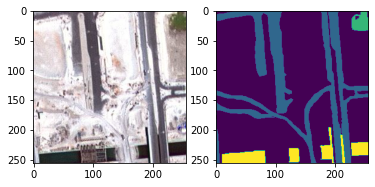

In [95]:
plt.subplot(1,2,1)
plt.imshow(img_train[10])
plt.subplot(1,2,2)
mask = np.argmax(mask_train, axis=3)
print(mask.shape)
plt.imshow(mask[10])

In [97]:
n_img, n_mask = Augmentation(img_train[10], mask[10], 100, RGB = True)

AttributeError: module 'tensorflow_core.keras.layers.experimental.preprocessing' has no attribute 'RandomRotation'

In [26]:
#Generate the model
class Conv(tf.keras.models.Model):
  def __init__(self, filters = 256, layers = 3):
    super().__init__()
    self.conv = [tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), padding="same", activation="relu") for _ in range(layers)]
    self.drop = tf.keras.layers.Dropout(0.2)

  def call(self, input):
    x = input
    for i, layer in enumerate(self.conv):
      x = layer(x)
      if i == 0:
          x = self.drop(x)
    return x
  
  def plot_model(self):
    dims = (264,264,3)
    x = tf.keras.layers.Input(dims)
    return tf.keras.models.Model(inputs=[x], outputs=[self.call(x)])


class ConvUp(tf.keras.models.Model):
  def __init__(self, filters = 128, n_conv = 2, concatanation=True):
    super().__init__()
    self.concatanation = concatanation
    self.ConvTrans = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=(2,2), strides=(2,2))
    self.Conv = [tf.keras.layers.Conv2D(filters = filters, kernel_size=(3,3), padding="same", activation="relu") for _ in range(n_conv)]
    self.Drop = tf.keras.layers.Dropout(0.1)

  def call(self, input, shortcut):
    x = self.ConvTrans(input)
    for conv_layer in self.Conv:
      x = conv_layer(x)
    if self.concatanation:
      x = tf.keras.layers.concatenate([x, shortcut])
    x = self.Drop(x)
    return x

  def plot_model(self):
    dims_in = (264, 264, 3)
    dims_shortcut = (528,528,100)
    x1 = tf.keras.layers.Input(dims_in)
    x2 = tf.keras.layers.Input(dims_shortcut)
    return tf.keras.models.Model(inputs=[x1, x2], outputs=[self.call(x1,x2)])
  
class Unet(tf.keras.models.Model):
  def __init__(self, n_down_in = 2, n_up_in = 2, filters_down=(32,64,128), filters_up=(128,64), channels = 6):
    '''
    PARAMS
    n_down_in: number of convolutions inside each downsampling operation
    n_up_in: number of convolutions inside each upsampling operation
    filters_down: filters that we are using for each downsampling IMPORTANT: this parameter is used to set the number of downsampling layers NOT n_down
    filters_up: filters that we are using for each upsampling IMPORTANT: this parameter is used to set the number of downsampling layers NOT n_up
    
    Note: You will always define N - 
    try: unet = Unet(n_down_in=2, n_up_in=2, filters_down=(16,32,64,128,256), filters_up=(128,64,32,16))
    '''
    super().__init__()
    self.down = [Conv(filters=i, layers=n_down_in) for i in (filters_down)]
    self.up = [ConvUp(filters=i, n_conv=n_up_in, concatanation=True) for i in (filters_up)]
    self.out = tf.keras.layers.Conv2D(channels, (1,1), activation="softmax")
    self.max = tf.keras.layers.MaxPool2D((2,2))
    for i in range(len(filters_down)):
      vars(self)[f'down_{i}'] = 0
    for i in range(len(filters_up)):
      vars(self)[f'up_{i}'] = 0

  def call(self, input):
    self.down_0 = self.down[0](input)
    for i,Down_layer in enumerate(self.down[1:]):
      vars(self)[f'down_{i+1}'] = self.max(vars(self)[f'down_{i}'])
      vars(self)[f'down_{i+1}'] = Down_layer(vars(self)[f'down_{i+1}']) #For the Down layers you have len(list) variables (because you are adding the input)
      
    self.up_0 = self.up[0](vars(self)[f'down_{len(self.down)-1}'], vars(self)[f'down_{len(self.down)-2}'])

    for i,Up_layer in enumerate(self.up[1:]):
      #print(f'up_{len(self.up)-1}')
      vars(self)[f'up_{i+1}']= Up_layer(vars(self)[f'up_{i}'], vars(self)[f'down_{len(self.down)-(i+3)}']) #For the Up layers you have len(list) - 1  variables
    
    x = self.out(vars(self)[f'up_{len(self.up)-1}']) 

    return x

  def plot_model(self):
    dims_in = (256,256,3)
    x1 = tf.keras.layers.Input(dims_in)
    return tf.keras.models.Model(inputs=[x1], outputs=[self.call(x1)])

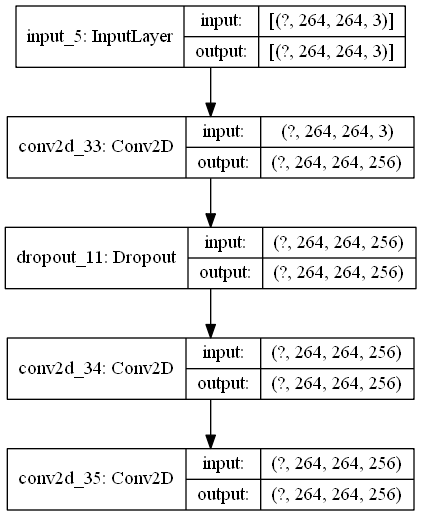

In [27]:
#Let's visualize one block of our encoding architecture
down = Conv()
tf.keras.utils.plot_model(down.plot_model(), to_file="model.png", show_shapes=True)

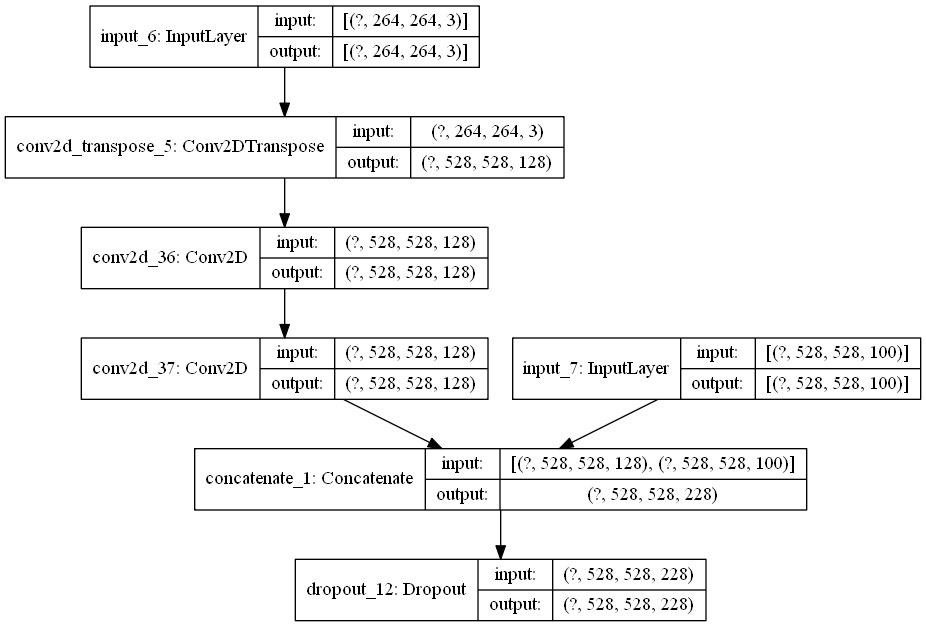

In [28]:
#Now let's visualize one block of our decoding architecture
up = ConvUp()
tf.keras.utils.plot_model(up.plot_model(), to_file="model.png", show_shapes=True)

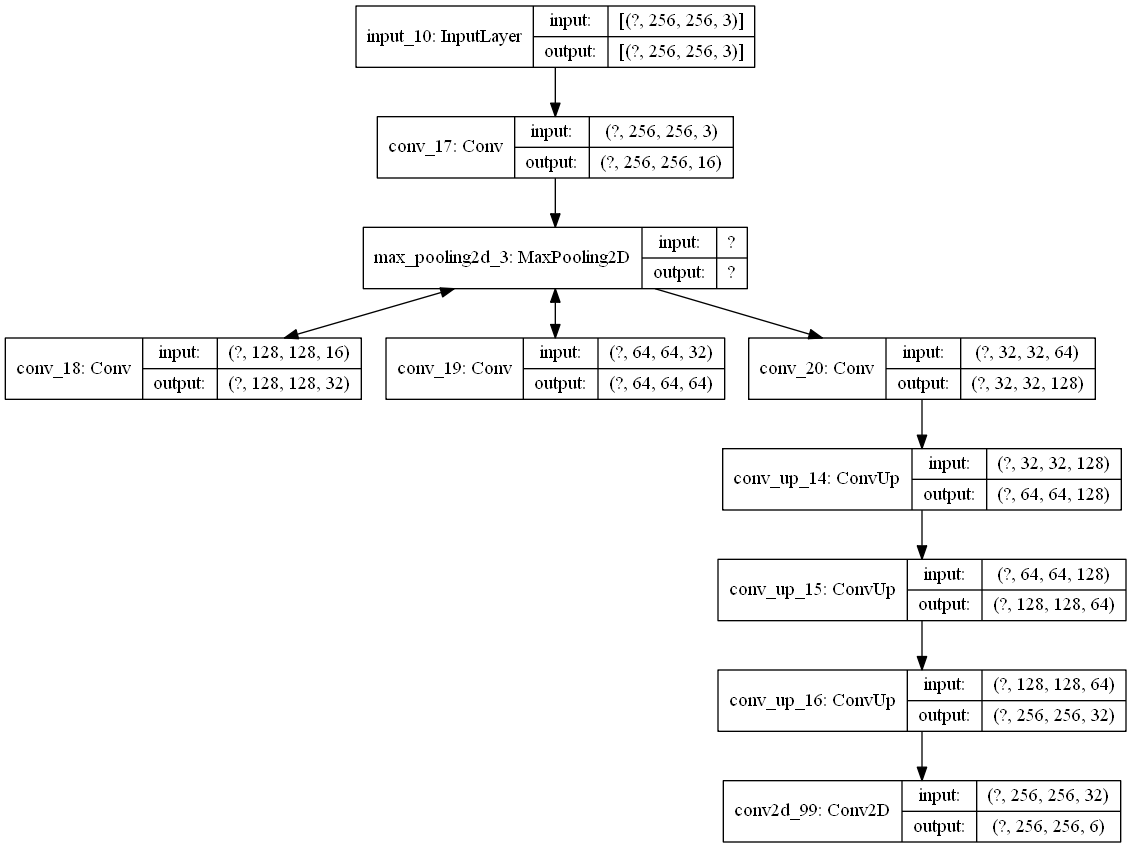

In [39]:
#Now, let's generate the entire architecture. Read the description in the above function to understand the parameters
unet = Unet(n_down_in=2, n_up_in=2, filters_down=(16,32,64,128), filters_up=(64,32,16))
tf.keras.utils.plot_model(unet.plot_model(), to_file="model.png", show_shapes=True)

In [40]:
#Define jacard coefficient is essentially a method to quantify the percent overlap between the target mask and our prediction output
#This will help us to evaluate how good or bad the model performed

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

In [41]:
#Define the loss function
weights = [0.16666, 0.16666, 0.16666, 0.16666, 0.16666, 0.16666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) 

In [42]:
#Compile the model
unet.compile(loss = total_loss, optimizer = "adam", metrics=["accuracy", jacard_coef])

In [45]:
#Train
history1 = unet.fit(img_train, mask_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(img_test, mask_test), 
                    shuffle=False)

Train on 1044 samples, validate on 261 samples
Epoch 1/100
1044/1044 [==============================] - 34s 33ms/sample - loss: 0.9763 - accuracy: 0.6561 - jacard_coef: 0.3437 - val_loss: 0.9750 - val_accuracy: 0.6529 - val_jacard_coef: 0.3575. - ETA: 0s - loss: 0.9763 - accuracy: 0.6571 - jacard_coef: 0.
Epoch 2/100
1044/1044 [==============================] - 31s 30ms/sample - loss: 0.9644 - accuracy: 0.6978 - jacard_coef: 0.4105 - val_loss: 0.9580 - val_accuracy: 0.7095 - val_jacard_coef: 0.4476.9663 - accuracy: 0.6908 - jacard_coef: 0. - ETA: 6s - loss: 0.9664 - accuracy: 0.6903 - ETA: 3s - loss: 0.9652 - accuracy: 0.6930 - - ETA: 1s - loss: 0.9651 - accuracy: 0.6961 - jacard_co - ETA: 0s - loss: 0.9644 - accuracy: 0.6993 - jacard_coef: 
Epoch 3/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9553 - accuracy: 0.7251 - jacard_coef: 0.4755 - val_loss: 0.9479 - val_accuracy: 0.7375 - val_jacard_coef: 0.4935.9604 - accuracy: 0.7 - ETA: 16s - loss: 0.9591 - ac

1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9141 - accuracy: 0.8454 - jacard_coef: 0.6711 - val_loss: 0.9151 - val_accuracy: 0.8464 - val_jacard_coef: 0.6834
Epoch 31/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9123 - accuracy: 0.8498 - jacard_coef: 0.6796 - val_loss: 0.9146 - val_accuracy: 0.8470 - val_jacard_coef: 0.6888
Epoch 32/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9131 - accuracy: 0.8478 - jacard_coef: 0.6759 - val_loss: 0.9143 - val_accuracy: 0.8464 - val_jacard_coef: 0.6878ard_coef: 0.66 - ETA: 3s - loss: 0.9135 - accu
Epoch 33/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9127 - accuracy: 0.8493 - jacard_coef: 0.6789 - val_loss: 0.9150 - val_accuracy: 0.8441 - val_jacard_coef: 0.6870
Epoch 34/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9114 - accuracy: 0.8514 - jacard_coef: 0.6833 - val_loss: 0.9128 - val_accuracy: 0.8501 - v

1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9012 - accuracy: 0.8679 - jacard_coef: 0.7241 - val_loss: 0.9136 - val_accuracy: 0.8505 - val_jacard_coef: 0.7077oss: 0.9022 -  - ETA: 12s - loss: 0.9028 - accuracy - ETA: 8s - loss: 0.9025 - accuracy:  - ETA: 5s - loss: 0.9017 - accuracy: 0.8663 - jacard_coef: 0. - ETA: 4s - loss: 0.9015 - accuracy:  - ETA: 1s - loss: 0.9012 - accuracy: 0.8676 - j
Epoch 59/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.9002 - accuracy: 0.8704 - jacard_coef: 0.7286 - val_loss: 0.9142 - val_accuracy: 0.8474 - val_jacard_coef: 0.702912s - loss: 0.9005
Epoch 60/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.8995 - accuracy: 0.8723 - jacard_coef: 0.7322 - val_loss: 0.9131 - val_accuracy: 0.8510 - val_jacard_coef: 0.7075
Epoch 61/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.8991 - accuracy: 0.8730 - jacard_coef: 0.7337 - val_loss: 0.9131 - val_accuracy:

1044/1044 [==============================] - 29s 28ms/sample - loss: 0.8919 - accuracy: 0.8891 - jacard_coef: 0.7627 - val_loss: 0.9097 - val_accuracy: 0.8607 - val_jacard_coef: 0.7278
Epoch 90/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.8924 - accuracy: 0.8878 - jacard_coef: 0.7607 - val_loss: 0.9097 - val_accuracy: 0.8588 - val_jacard_coef: 0.7210
Epoch 91/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.8916 - accuracy: 0.8896 - jacard_coef: 0.7636 - val_loss: 0.9113 - val_accuracy: 0.8564 - val_jacard_coef: 0.7208.8911 - ac
Epoch 92/100
1044/1044 [==============================] - 29s 28ms/sample - loss: 0.8911 - accuracy: 0.8908 - jacard_coef: 0.7660 - val_loss: 0.9104 - val_accuracy: 0.8587 - val_jacard_coef: 0.7226oss: 0.8919 - accuracy: 0 - ETA: 16s - loss: 0.8908 - accura - ETA: 9s - loss: 0.8914 - accuracy: 0.8882 -  - ETA: 7s - loss: 0.891 - ETA: 3s - loss: 0.8907 - accuracy: 0. - ETA: 0s - loss: 0.8911 - accuracy: 0.8

dict_keys(['loss', 'accuracy', 'jacard_coef', 'val_loss', 'val_accuracy', 'val_jacard_coef'])


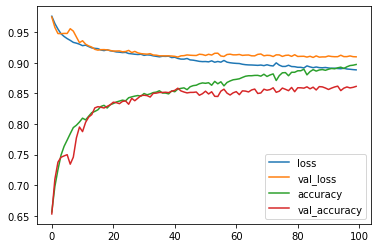

In [61]:
#Check your loss
print(history1.history.keys())
plt.plot(history1.history["loss"], label="loss")
plt.plot(history1.history["val_loss"], label="val_loss")
plt.plot(history1.history["accuracy"], label="accuracy")
plt.plot(history1.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [66]:
#Save model. Since we are using a subclass model, use save weights. The reason why you should not use save method
#For subclass model is that the architecture of the model is defined in the body of the call method. Therefore,
#It can't be serialized properly. This checkpoint will contain the layer's weights and optimization state
unet.save_weights(r'D:\Datasets\aeri_dubai\model\satellite_standard_unet_batch8_filters_down=(16,32,64,128)_filters_up=(64,32,16)_100epochs\satellite_standard_unet_batch8_filters_down=(16,32,64,128)_filters_up=(64,32,16)_100epochs', save_format='tf')

In [72]:
#Predict the test_ images
predictions = unet.predict(img_test)
predictions_argmax = np.argmax(predictions, axis=3)
gt_argmax = np.argmax(mask_test, axis=3)
print(predictions_argmax.shape, gt_argmax.shape)

(261, 256, 256) (261, 256, 256)


Text(0.5, 1.0, 'Prediction')

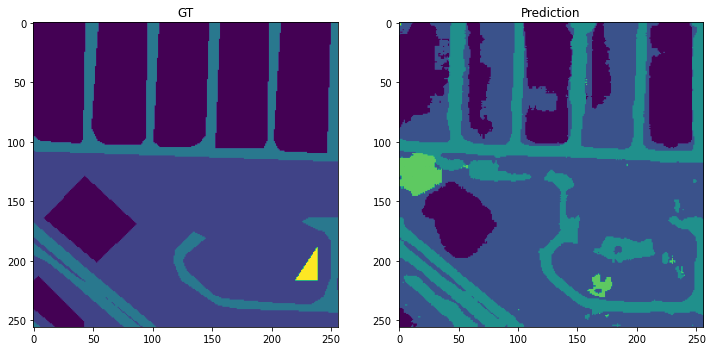

In [84]:
n = np.random.randint(0, predictions_argmax.shape[0])
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(gt_argmax[n])
plt.title("GT")
plt.subplot(1,2,2)
plt.imshow(predictions_argmax[n])
plt.title("Prediction")

In [82]:
#Calculate IoU
#If the prediction is completely correct, IoU = 1. The lower the IoU, the worse the prediction result
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(gt_argmax, predictions_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.60592467
